In [174]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

In [175]:
def get_CSI(CSI_RAW): # Function to extract the CSI information from CSV file rows
    string = CSI_RAW
    res = string.split(' ')
    numbers = []
    for token in res:
        numbers.append(int(token))
    return numbers

In [176]:
common = "../training_data/2-07-2025-"
dist = ["2m","5m"]
degree2m = ["2m_-45", "2m_-90", "2m-0", "2m-45", "2m-90"]
degree5m = ["5m--45", "5m--90", "5m-0", "5m-45", "5m-90"]
degree_all = degree2m + degree5m
end = "deg-training-set.csv"

In [ ]:
used = degree_all # Select which data to use: 2m, 5m or both
n_class = len(used)

datas = []
n_data_total = 0 
n_datas = []

used_features = [0,1,2,3,4] # 0: aoa, 1: master_rssi, 2: worker_rssi, 3: IQ_master, 4: = IQ_worker, random: 5

handle_data = 0 # 0: keep all original data (data amount biases will affect the model), 1: take the minimum number of rows for each location, 2: pad data from all locations to have the n_data = maximum

used_dict = {0: "aoa", 1: "master_rssi", 2: "worker_rssi", 3: "IQ_master", 4:"IQ_worker", 5:"random"}
dict_data = {0: "All original data", 1: "cut: respective to minimum amount of data", 2: "padded: respective to maximum amount of data"}

In [178]:
minimum = 9999999 # placeholder for minimum of data samples between locations (degree&distance)
maximum = 0 # placeholder for maximum of data samples between locations (degree&distance)

for i, location in enumerate(used):
    filename = common + location + end
    df = pd.read_csv(filename)

    df = df[['aoa', 'master_rssi', 'worker_rssi', 'IQ_master', 'IQ_worker']] # df[['aoa', 'master_rssi', 'worker_rssi', 'IQ_master', 'IQ_worker']]
    data = df.to_numpy()

    n_data = data.shape[0]

    if n_data < minimum:
        minimum = n_data

    if n_data > maximum:
        maximum = n_data

    rnd = np.zeros((n_data,1)) # add random column for testing purposes

    i_csi_m = 3
    i_csi_w = 4
    for i in range(n_data):
        data[i][i_csi_m] = get_CSI(data[i][i_csi_m])
        data[i][i_csi_w] = get_CSI(data[i][i_csi_w])
    data = np.append(data, rnd, 1)

    data = data[:,used_features]

    datas.append(data)
    n_datas.append(n_data)
    n_data_total += n_data

In [179]:
len_feature = 0
for feat in datas[0][0]:
    try: 
        len_feature += len(feat)
    except:
        len_feature += 1

n_used = 0
if handle_data == 0:
    n_used = n_data_total
elif handle_data == 1:
    n_used = n_class * minimum
else:
    n_used = n_class * maximum

X = np.zeros((n_used, len_feature))
Y = np.zeros((n_used, n_class))

In [180]:
start_index = 0

if handle_data == 0: # All possible data
    for i, data in enumerate(datas): # one measurement/location/class
        for j, val in enumerate(data): # one instance/line/rssi+CSI+etc of the location
            feature = []
            for f in val: # aoa, rssi etc of one measurement
                if type(f) == list:
                    for v in f:
                        feature.append(v)
                else:
                    feature.append(f)
            X[start_index + j,:] = np.array(feature) # np.zeros(len_feature) + i#
            Y[start_index + j,i] = 1
        start_index += n_datas[i]
elif handle_data == 1: # With respective to minimum amount 
    for i, data in enumerate(datas): 
        for j in range(minimum): 
            feature = []
            val = data[j]
            for f in val:
                if type(f) == list:
                    for v in f:
                        feature.append(v)
                else:
                    feature.append(f)
            X[start_index + j,:] = np.array(feature) 
            Y[start_index + j,i] = 1
        start_index += minimum
else: # With respective to maximum amount
    for i, data in enumerate(datas): 
        n_data = n_datas[i]
        for j in range(maximum): 
            feature = []
            ind = j%n_data
            val = data[ind]
            for f in val: 
                if type(f) == list:
                    for v in f:
                        feature.append(v)
                else:
                    feature.append(f)
            X[start_index + j,:] = np.array(feature) 
            Y[start_index + j,i] = 1
        start_index += maximum

In [181]:
# normalize

# mean = np.mean(X)
# std = np.std(X)

# mi = np.min(X)
# ma = np.max(X)

# # X = X - mean
# # X = X / std
# X = (X-mi)/(ma-mi)

# shuffle inputs
indsh = (np.arange(n_used))
np.random.shuffle(indsh)

X = X[indsh,:]
Y = Y[indsh]

X_train = X[:int(0.7 * n_used),:]
y_train = Y[:int(0.7 * n_used),:]

X_val = X[int(0.7 * n_used):int(0.8 * n_used),:]
y_val = Y[int(0.7 * n_used):int(0.8 * n_used),:]

X_test = X[int(0.8 * n_used):,:]
y_test = Y[int(0.8 * n_used):,:]

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, feature, label):
        self.feature = feature
        self.label = label

    def __len__(self):
        return len(self.feature)

    def __getitem__(self, idx):
        x = self.feature[idx, :]
        y = self.label[idx, :]
        return x, y

# Create Dataset objects
train_data = CustomDataset(torch.Tensor(X_train), torch.Tensor(y_train))
val_data = CustomDataset(torch.Tensor(X_val), torch.Tensor(y_val))
test_data = CustomDataset(torch.Tensor(X_test), torch.Tensor(y_test))

# Create DataLoader for training, validation, and test sets
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [182]:
print(X_val.shape)

(122, 1)


In [183]:
layers = [256,128,64,32,16] # layer sizes


shared_layers = nn.Sequential(
    nn.Linear(len_feature, layers[0], bias=True),
    nn.ReLU(),
    nn.BatchNorm1d(layers[0]),
    nn.Linear(layers[0], layers[1], bias=True),
    nn.ReLU(),
    nn.BatchNorm1d(layers[1]),
    nn.Linear(layers[1], layers[2], bias=True),
    nn.ReLU(),
    nn.BatchNorm1d(layers[2]),
    nn.Linear(layers[2], layers[3], bias=True),
    nn.ReLU(),
    nn.BatchNorm1d(layers[3]),
    nn.Linear(layers[3], layers[4], bias=True),
    nn.ReLU(),
    nn.BatchNorm1d(layers[4]),
    nn.Linear(layers[4], n_class, bias=True) # Last dim is the amount classes / locations
)

class My_NN(nn.Module):
        def __init__(self):
            super(My_NN, self).__init__()
            self.block = shared_layers

        def _initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.kaiming_uniform_(m.weight)
                    nn.init.zeros_(m.bias)
                elif isinstance(m, nn.BatchNorm1d):
                    nn.init.ones_(m.weight)
                    nn.init.zeros_(m.bias)

        def forward(self, feature):
            output = self.block(feature)

            return output

100%|██████████| 200/200 [00:05<00:00, 36.95it/s]


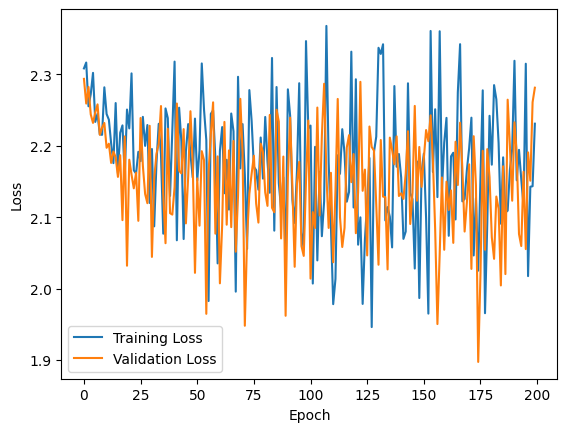

In [184]:
# Initialize the model and other hyperparameters
my_nn = My_NN()
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_nn.parameters(), lr=0.001, momentum=0.9)

my_nn.train()
num_epochs = 200
print_parameters_every = 20  # Print parameters every n epochs
train_losses = []
validation_losses = []
for epoch in tqdm(range(num_epochs)):
    for feature_batch, labels_batch in train_loader:  
        output = my_nn(feature_batch)  
        loss = criterion(output, labels_batch)  
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(loss.item())  # Store training loss
    # validation loop
    with torch.no_grad():
        for feature_batch, labels_batch in val_loader:
            output = my_nn(feature_batch) 
            val_loss = criterion(output, labels_batch)
            # scheduler.step(val_loss)  # you may add the scheduler to avoid over-fitting by reducing learning rate

        validation_losses.append(val_loss.item())
# Plot the training and validation loss
plt.figure(1)
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [185]:
# test loop
my_nn.eval()
correct = 0
total = 0
with torch.no_grad():
    for feature_batch, labels_batch in test_loader:
        output = my_nn(feature_batch) 
        _,pred = torch.max(output,1)
        _, real = torch.max(labels_batch,1)
        total += len(real)
        correct += (pred == real).sum().item()

print("Accuracy:", correct/total)
print("Num. of used measurements:", len(used))
print("Used features:")
for i in used_features:
    print(" ",used_dict[i])
print("Data handling: ", dict_data[handle_data])


Accuracy: 0.11607142857142858
Num. of used measurements: 10
Used features:
  random
Data handling:  All original data
